In [1]:
import mpramnist
from mpramnist.suredataset import SureDataset
from mpramnist import transforms as t
from mpramnist import target_transforms as t_t

import pandas as pd
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from tqdm import tqdm

In [2]:
BATCH_SIZE = 1024
NUM_WORKERS = 103

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
from torch.nn.utils.rnn import pad_sequence

# preprocessing
train_transform = t.Compose([
    t.Seq2Tensor(),
    t.ReverseComplement(0.5),
])
test_transform = t.Compose([ # трансформы теста слегка другие
    t.Seq2Tensor(), 
])

def pad_collate(batch):
    (seq, targets) = zip(*batch)

    seq = pad_sequence(seq, batch_first=True, padding_value=0.25)

    return seq, torch.vstack(targets)

# LegNet

In [7]:
import math

import torch
import torch.nn as nn
import torch.nn.functional as F

def initialize_weights(m):
    if isinstance(m, nn.Conv1d):
        n = m.kernel_size[0] * m.out_channels
        m.weight.data.normal_(0, math.sqrt(2 / n))
        if m.bias is not None:
            nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.BatchNorm1d):
        nn.init.constant_(m.weight.data, 1)
        nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.Linear):
        m.weight.data.normal_(0, 0.001)
        if m.bias is not None:
            nn.init.constant_(m.bias.data, 0)

class SELayer(nn.Module):
    def __init__(self, inp, reduction=4):
        super(SELayer, self).__init__()
        self.fc = nn.Sequential(
                nn.Linear(inp, int(inp // reduction)),
                nn.SiLU(),
                nn.Linear(int(inp // reduction), inp),
                nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, = x.size()
        y = x.view(b, c, -1).mean(dim=2)
        y = self.fc(y).view(b, c, 1)
        return x * y

class EffBlock(nn.Module):
    def __init__(self, in_ch, ks, resize_factor, activation, out_ch=None, se_reduction=None):
        super().__init__()
        self.in_ch = in_ch
        self.out_ch = self.in_ch if out_ch is None else out_ch
        self.resize_factor = resize_factor
        self.se_reduction = resize_factor if se_reduction is None else se_reduction
        self.ks = ks
        self.inner_dim = self.in_ch * self.resize_factor

        block = nn.Sequential(
                        nn.Conv1d(
                            in_channels=self.in_ch,
                            out_channels=self.inner_dim,
                            kernel_size=1,
                            padding='same',
                            bias=False
                       ),
                       nn.BatchNorm1d(self.inner_dim),
                       activation(),

                       nn.Conv1d(
                            in_channels=self.inner_dim,
                            out_channels=self.inner_dim,
                            kernel_size=ks,
                            groups=self.inner_dim,
                            padding='same',
                            bias=False
                       ),
                       nn.BatchNorm1d(self.inner_dim),
                       activation(),
                       SELayer(self.inner_dim, reduction=self.se_reduction),
                       nn.Conv1d(
                            in_channels=self.inner_dim,
                            out_channels=self.in_ch,
                            kernel_size=1,
                            padding='same',
                            bias=False
                       ),
                       nn.BatchNorm1d(self.in_ch),
                       activation(),
        )

        self.block = block

    def forward(self, x):
        return self.block(x)

class LocalBlock(nn.Module):
    def __init__(self, in_ch, ks, activation, out_ch=None):
        super().__init__()
        self.in_ch = in_ch
        self.out_ch = self.in_ch if out_ch is None else out_ch
        self.ks = ks

        self.block = nn.Sequential(
                       nn.Conv1d(
                            in_channels=self.in_ch,
                            out_channels=self.out_ch,
                            kernel_size=self.ks,
                            padding='same',
                            bias=False
                       ),
                       nn.BatchNorm1d(self.out_ch),
                       activation()
        )

    def forward(self, x):
        return self.block(x)

class ResidualConcat(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, **kwargs):
        return torch.concat([self.fn(x, **kwargs), x], dim=1)

class MapperBlock(nn.Module):
    def __init__(self, in_features, out_features, activation=nn.SiLU):
        super().__init__()
        self.block = nn.Sequential(
            nn.BatchNorm1d(in_features),
            nn.Conv1d(in_channels=in_features,
                      out_channels=out_features,
                      kernel_size=1),
        )

    def forward(self, x):
        return self.block(x)

class HumanLegNet(nn.Module):
    def __init__(self,
                 in_ch,
                 output_dim,
                 stem_ch,
                 stem_ks,
                 ef_ks,
                 ef_block_sizes,
                 pool_sizes,
                 resize_factor,
                 activation=nn.SiLU,
                 ):
        super().__init__()
        assert len(pool_sizes) == len(ef_block_sizes)

        self.in_ch = in_ch
        self.stem = LocalBlock(in_ch=in_ch,
                               out_ch=stem_ch,
                               ks=stem_ks,
                               activation=activation)

        blocks = []
        self.output_dim = output_dim
        in_ch = stem_ch
        out_ch = stem_ch
        for pool_sz, out_ch in zip(pool_sizes, ef_block_sizes):
            blc = nn.Sequential(
                ResidualConcat(
                    EffBlock(
                        in_ch=in_ch,
                        out_ch=in_ch,
                        ks=ef_ks,
                        resize_factor=resize_factor,
                        activation=activation)
                ),
                LocalBlock(in_ch=in_ch * 2,
                           out_ch=out_ch,
                           ks=ef_ks,
                           activation=activation),
                nn.MaxPool1d(pool_sz) if pool_sz != 1 else nn.Identity()
            )
            in_ch = out_ch
            blocks.append(blc)
        self.main = nn.Sequential(*blocks)

        self.mapper = MapperBlock(in_features=out_ch,
                                  out_features=out_ch * 2)
        self.head = nn.Sequential(nn.Linear(out_ch * 2, out_ch * 2),
                                   nn.BatchNorm1d(out_ch * 2),
                                   activation(),
                                   nn.Linear(out_ch * 2, self.output_dim))

    def forward(self, x):
        x = x.permute(0,2,1)
        x = self.stem(x)
        x = self.main(x)
        x = self.mapper(x)
        x =  F.adaptive_avg_pool1d(x, 1)
        x = x.squeeze(-1)
        x = self.head(x)
        x = x.squeeze(-1)
        return x

# Classification

In [4]:
GENOME_IDS = SureDataset.GENOME_IDS
CELL_TYPES = SureDataset.cell_types

In [5]:
task = "classification"

# load the data
train_dataset = SureDataset(task = task, genome_id = GENOME_IDS[0], 
                            split="train", transform=train_transform)                                                                                              # for needed folds
val_dataset = SureDataset(task = task, genome_id = GENOME_IDS[0], 
                          split="val", transform=test_transform) # use "val" for default validation set
test_dataset = SureDataset(task = task, genome_id = GENOME_IDS[0], 
                           split="test", transform=test_transform) # use "test" for default test set
N_CLASSES = train_dataset.num_outputs
in_channels = len(train_dataset[0][0][0])

In [11]:
from sklearn.metrics import auc, roc_curve
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import precision_score, recall_score, precision_recall_curve, auc, average_precision_score, roc_auc_score
from sklearn.metrics import accuracy_score, f1_score

from sklearn.preprocessing import label_binarize
from itertools import cycle

def calculate_auroc(y_score, y_true, n_classes, ax=None):

    y_score = F.softmax(y_score.float(), dim=1).cpu().numpy()
    y_true = y_true.cpu().numpy()

    y = label_binarize(y_true, classes=np.arange(n_classes))
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    lw = 1
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y[:,i], y_score[:,i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    colors = ['orange', 'green', 'red', 'purple', 'brown', 'pink', 'blue', 'yellow', 'cyan']
    colors = cycle(colors[:n_classes])
    
    # Plot of a ROC curve for a specific class
    for i, color in zip(range(n_classes), colors):
        ax.plot(fpr[i], tpr[i], color=color, lw= 0.5,label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))
    
    ax.plot([0, 1], [0, 1], 'k--', lw=lw)
    ax.set_xlim([-0.05, 1.0])
    ax.set_ylim([0.0, 1.05])
    
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic for multi-class data')
    ax.legend(loc="lower right")

    return roc_auc_score(
        y_true,
        y_score,
        multi_class="ovr",
        average="macro",
    )

def calculate_aupr(y_score, y_true, n_classes, ax=None):
    y_score = F.softmax(y_score.float(), dim=1).cpu().numpy()
    y_pred = np.argmax(y_score, axis=1)
    y_true = y_true.cpu().numpy()
    
    df = pd.DataFrame({"predicted" : y_pred})
    
    ax.bar(np.arange(n_classes), np.bincount(y_pred, minlength=n_classes), color='skyblue', edgecolor='black')
    for i, count in enumerate(np.bincount(y_pred, minlength=n_classes)):
        ax.text(i, count, str(count), ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    ax.set_xlabel('Labels')
    ax.set_ylabel('Quantity')
    ax.set_title('Histogram count of label')
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    
    precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
    recall = recall_score(y_true, y_pred, average='macro')  
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro')

    y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))
    pr_auc = average_precision_score(y_true_bin, y_score, average="macro")
    return precision, recall, accuracy, f1, pr_auc
    
def roc_auc(seq_model, loader, n_classes = 10, figure = False):
    predictions = trainer.predict(seq_model, dataloaders=loader)
    
    targets = torch.cat([pred["y"] for pred in predictions])
    y_preds = torch.cat([pred["pred"] for pred in predictions])

    # K562
    if figure:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    auroc = calculate_auroc(y_preds[:,0:5], targets[:,0], n_classes//2, ax1 if figure else None) 
    precision, recall, accuracy, f1, aupr = calculate_aupr(y_preds[:,0:5], targets[:,0], n_classes//2, ax2 if figure else None) 
    
    res_str = '|' + f" {CELL_TYPES[0]}: |" + ' {}: {:.5f} |'.format("Precision", precision)
    res_str += ' {}: {:.5f} |'.format("Recall", recall)
    res_str += ' {}: {:.5f} |'.format("Accuracy", accuracy)
    res_str += ' {}: {:.5f} |'.format("F1", f1)
    res_str += ' {}: {:.5f} |'.format("AUCROC", auroc)
    res_str += ' {}: {:.5f} |'.format("AUPR", aupr)
    
    border = '-'*len(res_str)
    print("\n".join(['',border, res_str, border,'']))

    if figure:
        plt.tight_layout()
        plt.show()

    if figure:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    auroc = calculate_auroc(y_preds[:,5:10], targets[:,1], n_classes//2, ax1 if figure else None) 
    precision, recall, accuracy, f1, aupr = calculate_aupr(y_preds[:,5:10], targets[:,1], n_classes//2, ax2 if figure else None) 
    
    res_str = '|' + f" {CELL_TYPES[1]}: |" + ' {}: {:.5f} |'.format("Precision", precision)
    res_str += ' {}: {:.5f} |'.format("Recall", recall)
    res_str += ' {}: {:.5f} |'.format("Accuracy", accuracy)
    res_str += ' {}: {:.5f} |'.format("F1", f1)
    res_str += ' {}: {:.5f} |'.format("AUCROC", auroc)
    res_str += ' {}: {:.5f} |'.format("AUPR", aupr)
    border = '-'*len(res_str)
    print("\n".join(['',border, res_str, border,'']))

    if figure:
        plt.tight_layout()
        plt.show()
        

## Train Classification

In [8]:
import pytorch_lightning as L
from torch.nn import functional as F
from sklearn.metrics import average_precision_score
from sklearn.preprocessing import label_binarize
    
class Seq1Model(L.LightningModule):
    
    def __init__(self, in_ch, out_ch = 10, lr=3e-4):
        super().__init__()
        
        self.model = HumanLegNet(in_ch=in_ch,
                                 output_dim = out_ch,
                                 stem_ch=64,
                                 stem_ks=11,
                                 ef_ks=9,
                                 ef_block_sizes=[80, 96, 112, 128],
                                 pool_sizes=[2,2,2,2],
                                 resize_factor=4)
        self.model.apply(initialize_weights)

        self.loss = torch.nn.CrossEntropyLoss().to(device) # for classification
        self.lr = lr

        self.n_classes = out_ch
        
        self.y_score = torch.tensor([], device=device)
        self.y_true = torch.tensor([], device=device)
        
        self.train_loss = torch.tensor([], device=device)
        self.val_loss = torch.tensor([], device=device)
        
    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_nb):
        X, y = batch
        y_hat = self.model(X)
        y = y.long()

        loss = self.loss(y_hat[:, 0:5], y[:,0])
        loss += self.loss(y_hat[:, 5:10], y[:,1])
        
        self.log("train_loss", loss, prog_bar=True,  on_step=True, on_epoch=True, logger = True)
        self.train_loss = torch.cat([self.train_loss, loss.unsqueeze(0)])
        
        lr = self.optimizers().param_groups[0]['lr']  # Get current learning rate
        self.log('learning_rate', lr, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)
        y = y.long()

        loss = self.loss(y_hat[:, 0:5], y[:,0])
        loss += self.loss(y_hat[:, 5:10], y[:,1])
        
        self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        self.val_loss = torch.cat([self.val_loss, loss.unsqueeze(0)])

        self.y_score = torch.cat([self.y_score, y_hat])
        self.y_true = torch.cat([self.y_true, y])
        
    def on_validation_epoch_end(self):
        val_loss = self.val_loss.mean()
        
        auroc = self.calculate_auroc(y_score=self.y_score[:, 0:5], y_true=self.y_true[:,0], n_classes=self.n_classes//2) 
        arr, precision, recall, accuracy, f1, aupr = self.calculate_aupr(y_score=self.y_score[:, 0:5], y_true=self.y_true[:,0],
                                                                         n_classes=self.n_classes//2) 

        res_str = '|' + ' {}: {:.5f} |'.format("Current_epoch", self.current_epoch) 
        res_str += ' {}: {:.5f} |'.format("Val_loss", val_loss)
        if len(self.train_loss) != 0:
            train_loss = self.train_loss.mean()
            res_str += ' {}: {:.5f} |'.format("Train_loss", train_loss)
            self.train_loss = torch.tensor([], device=device)
        res_str += "\n"
        res_str += f"| {CELL_TYPES[0]}: |"
        res_str += "\n"
        res_str += '| {}: {} |'.format("Number of predicted values", arr)
        res_str += "\n"
        res_str += '| {}: {:.5f} |'.format("Precision", precision)
        res_str += ' {}: {:.5f} |'.format("Recall", recall)
        res_str += ' {}: {:.5f} |'.format("Accuracy", accuracy)
        res_str += ' {}: {:.5f} |'.format("F1", f1)
        res_str += ' {}: {:.5f} |'.format("Val_AUCROC", auroc)
        res_str += ' {}: {:.5f} |'.format("Val_AUPR", aupr)
        res_str += "\n"

        auroc = self.calculate_auroc(y_score=self.y_score[:, 5:10], y_true=self.y_true[:,1], n_classes=self.n_classes//2) 
        arr, precision, recall, accuracy, f1, aupr = self.calculate_aupr(y_score=self.y_score[:, 5:10], y_true=self.y_true[:,1],
                                                                         n_classes=self.n_classes//2) 

        res_str += f"| {CELL_TYPES[1]}: |"
        res_str += "\n"
        res_str += '| {}: {} |'.format("Number of predicted values", arr)
        res_str += "\n"
        res_str += '| {}: {:.5f} |'.format("Precision", precision)
        res_str += ' {}: {:.5f} |'.format("Recall", recall)
        res_str += ' {}: {:.5f} |'.format("Accuracy", accuracy)
        res_str += ' {}: {:.5f} |'.format("F1", f1)
        res_str += ' {}: {:.5f} |'.format("Val_AUCROC", auroc)
        res_str += ' {}: {:.5f} |'.format("Val_AUPR", aupr)
            
        border = '-'*100
        print("\n".join(['',border, res_str, border,'']))

        self.val_loss = torch.tensor([], device=device)
        self.y_score = torch.tensor([], device=device)
        self.y_true = torch.tensor([], device=device)
        return None

    def test_step(self, batch, _):
        x, y = batch
        y_hat = self.model(x)
        y = y.long()

        loss = self.loss(y_hat[:, 0:5], y[:,0])
        loss += self.loss(y_hat[:, 5:10], y[:,1])
        self.log('test_loss', 
                 loss, 
                 prog_bar=True, 
                 on_step=False,
                 on_epoch=True)

    def calculate_auroc(self, y_score, y_true, n_classes):
        y_score = F.softmax(y_score.float(), dim=1).cpu().numpy()
        y_true = y_true.cpu().numpy()

        y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))
        
        return roc_auc_score(y_true_bin, y_score, multi_class="ovr", average="macro")

    def calculate_aupr(self, y_score, y_true, n_classes):
        y_score = F.softmax(y_score.float(), dim=1).cpu().numpy()
        y_pred = np.argmax(y_score, axis=1)
        y_true = y_true.cpu().numpy()
        
        arr = []
        for i in range(n_classes):
            arr.append(y_pred.tolist().count(i))
        
        precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
        recall = recall_score(y_true, y_pred, average='macro', zero_division = 0)  
        accuracy = accuracy_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred, average='macro')

        y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))
        pr_auc = average_precision_score(y_true_bin, y_score, average="macro")
        return arr, precision, recall, accuracy, f1, pr_auc

    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        x, y = batch
        y_hat = self.model(x)          
        
        return {"y": y.squeeze().long().cpu().detach().float(), "pred": y_hat.cpu().detach().float()}
        
    def train_dataloader(self):
        return data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, 
                               num_workers = NUM_WORKERS, pin_memory=True, collate_fn=pad_collate)

    def val_dataloader(self):
        return data.DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False, 
                               num_workers = NUM_WORKERS, pin_memory=True, collate_fn=pad_collate)
    
    def test_dataloader(self):
        return data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, 
                               num_workers = NUM_WORKERS, pin_memory=True, collate_fn=pad_collate)


    def configure_optimizers(self):
        
        self.optimizer = torch.optim.AdamW(self.parameters(),
                                               lr=self.lr,
                                               weight_decay = 1e-2)
        
        lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(self.optimizer, # type: ignore
                                                        max_lr=self.lr,
                                                        three_phase=False, 
                                                        total_steps=self.trainer.estimated_stepping_batches, # type: ignore
                                                        pct_start=0.3,
                                                        cycle_momentum =False)
        lr_scheduler_config = {
                    "scheduler": lr_scheduler,
                    "interval": "step",
                    "frequency": 1,
                    "name": "cycle_lr"
            }
            
        return [self.optimizer], [lr_scheduler_config]

In [12]:
seq_model = Seq1Model(in_ch = in_channels, out_ch = N_CLASSES, lr = 1e-2)

# Initialize a trainer
trainer = L.Trainer(
    accelerator="gpu",
    devices=[0],
    max_epochs=5,
    gradient_clip_val=1,
    precision='16-mixed', 
    enable_progress_bar = True,
    num_sanity_val_steps=0
)

# Train the model
trainer.fit(seq_model)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loading `train_dataloader` to estimate number of stepping batches.

  | Name  | Type             | Params | Mode 
---------------------------------------------------
0 | model | HumanLegNet      | 1.3 M  | train
1 | loss  | CrossEntropyLoss | 0      | train
---------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.299     Total estimated model params size (MB)
117       Modules in train mode
0         Modules in eval mode


Training: |                                                                                       | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| Current_epoch: 0.00000 | Val_loss: 3.12574 | Train_loss: 3.00374 |
| K562: |
| Number of predicted values: [45202, 9680, 16213, 1, 2839] |
| Precision: 0.44833 | Recall: 0.27619 | Accuracy: 0.27893 | F1: 0.20389 | Val_AUCROC: 0.65327 | Val_AUPR: 0.30092 |
| HepG2: |
| Number of predicted values: [39132, 13591, 12690, 3, 8519] |
| Precision: 0.34971 | Recall: 0.27611 | Accuracy: 0.27892 | F1: 0.22094 | Val_AUCROC: 0.61865 | Val_AUPR: 0.27168 |
----------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| Current_epoch: 1.00000 | Val_loss: 3.05055 | Train_loss: 2.93700 |
| K562: |
| Number of predicted values: [39725, 8099, 14370, 84, 11657] |
| Precision: 0.30438 | Recall: 0.31681 | Accuracy: 0.31758 | F1: 0.25869 | Val_AUCROC: 0.66727 | Val_AUPR: 0.32239 |
| HepG2: |
| Number of predicted values: [47518, 10992, 8312, 993, 6120] |
| Precision: 0.32155 | Recall: 0.27968 | Accuracy: 0.28252 | F1: 0.21836 | Val_AUCROC: 0.61960 | Val_AUPR: 0.27772 |
----------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| Current_epoch: 2.00000 | Val_loss: 3.00512 | Train_loss: 2.90266 |
| K562: |
| Number of predicted values: [32750, 13727, 19775, 150, 7533] |
| Precision: 0.33932 | Recall: 0.32667 | Accuracy: 0.32844 | F1: 0.27874 | Val_AUCROC: 0.68147 | Val_AUPR: 0.33253 |
| HepG2: |
| Number of predicted values: [36632, 17452, 3999, 93, 15759] |
| Precision: 0.30106 | Recall: 0.29939 | Accuracy: 0.30222 | F1: 0.23294 | Val_AUCROC: 0.64147 | Val_AUPR: 0.29470 |
----------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| Current_epoch: 3.00000 | Val_loss: 2.98276 | Train_loss: 2.87042 |
| K562: |
| Number of predicted values: [30887, 13146, 21884, 202, 7816] |
| Precision: 0.34197 | Recall: 0.32796 | Accuracy: 0.32961 | F1: 0.28375 | Val_AUCROC: 0.67904 | Val_AUPR: 0.33248 |
| HepG2: |
| Number of predicted values: [38930, 15577, 11180, 141, 8107] |
| Precision: 0.31117 | Recall: 0.30264 | Accuracy: 0.30576 | F1: 0.24474 | Val_AUCROC: 0.64836 | Val_AUPR: 0.30002 |
----------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…

`Trainer.fit` stopped: `max_epochs=5` reached.



----------------------------------------------------------------------------------------------------
| Current_epoch: 4.00000 | Val_loss: 2.95101 | Train_loss: 2.83632 |
| K562: |
| Number of predicted values: [28464, 13803, 23578, 442, 7648] |
| Precision: 0.35180 | Recall: 0.33768 | Accuracy: 0.33942 | F1: 0.29529 | Val_AUCROC: 0.68824 | Val_AUPR: 0.34138 |
| HepG2: |
| Number of predicted values: [35671, 14001, 12451, 265, 11547] |
| Precision: 0.30719 | Recall: 0.32053 | Accuracy: 0.32354 | F1: 0.26837 | Val_AUCROC: 0.65784 | Val_AUPR: 0.30896 |
----------------------------------------------------------------------------------------------------



LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: |                                                                                     | 0/? [00:00…


--------------------------------------------------------------------------------------------------------------------
| K562: | Precision: 0.33761 | Recall: 0.33011 | Accuracy: 0.33152 | F1: 0.29034 | AUCROC: 0.68131 | AUPR: 0.33649 |
--------------------------------------------------------------------------------------------------------------------



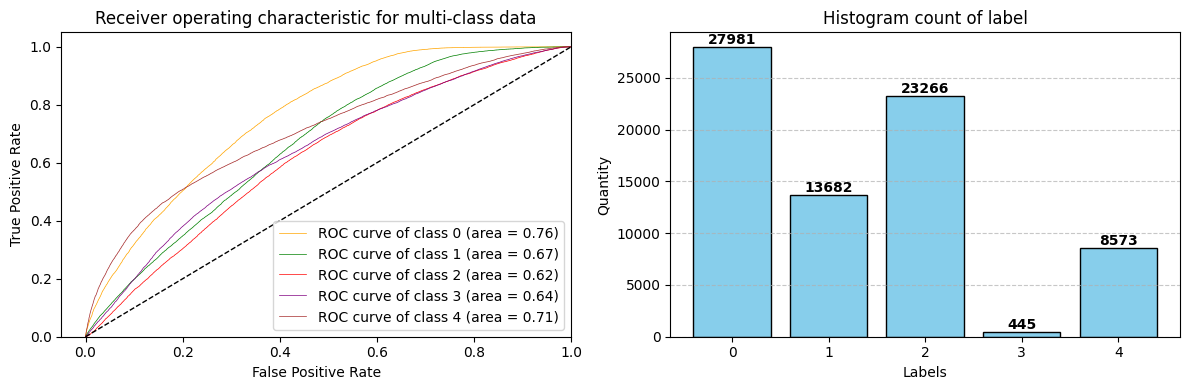


---------------------------------------------------------------------------------------------------------------------
| HepG2: | Precision: 0.31814 | Recall: 0.33006 | Accuracy: 0.33294 | F1: 0.28070 | AUCROC: 0.65500 | AUPR: 0.31457 |
---------------------------------------------------------------------------------------------------------------------



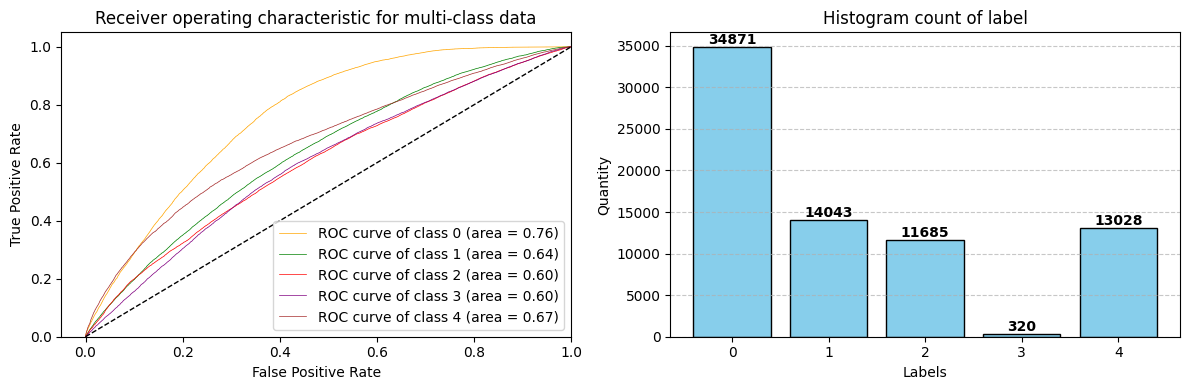

In [13]:
test_loader = data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False,
                              num_workers = NUM_WORKERS, pin_memory=True, collate_fn=pad_collate)
roc_auc(seq_model, test_loader, n_classes = N_CLASSES, figure = True)

# Regression

In [4]:
task = "regression"
GENOME_IDS = SureDataset.GENOME_IDS
CELL_TYPES = SureDataset.cell_types

train_dataset = SureDataset(task = task, genome_id = GENOME_IDS[0],
                            split="train", transform=train_transform)                                                               # for needed folds
val_dataset = SureDataset(task = task, genome_id = GENOME_IDS[0],
                          split="val", transform=test_transform) # use "val" for default validation set
test_dataset = SureDataset(task = task, genome_id = GENOME_IDS[0],
                           split="test", transform=test_transform) # use "test" for default test set

N_CLASSES = train_dataset.num_outputs
in_channels = len(train_dataset[0][0][0])

In [5]:
import pytorch_lightning as L
from torch.nn import functional as F
from torchmetrics import PearsonCorrCoef

def pearson_correlation(x, y):
    vx = x - torch.mean(x, dim=0)
    vy = y - torch.mean(y, dim=0)
    pearsons = torch.sum(vx * vy, dim=0) / (torch.sqrt(torch.sum(vx ** 2, dim=0)) * torch.sqrt(torch.sum(vy ** 2, dim=0)) + 1e-10)
    return torch.mean(pearsons)
    
class Seq1Model(L.LightningModule):
    
    def __init__(self, in_ch, weight_decay, out_ch = 2, lr=3e-4):
        super().__init__()
        
        self.model = HumanLegNet(in_ch=in_ch,
                                 output_dim = out_ch,
                                 stem_ch=64,
                                 stem_ks=11,
                                 ef_ks=9,
                                 ef_block_sizes=[80, 96, 112, 128],
                                 pool_sizes=[2,2,2,2],
                                 resize_factor=4)
        self.model.apply(initialize_weights)

        self.weight_decay = weight_decay
        
        self.loss = nn.MSELoss() 
        self.lr = lr
        
        self.n_classes = out_ch

        self.train_loss = torch.tensor([]).to(device)
        self.val_loss = torch.tensor([]).to(device)
        self.pred = torch.empty(0).to(device)
        self.target = torch.empty(0).to(device)
        
    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_nb):
        X, y = batch
        pred = self(X)

        loss = self.loss(pred, y)
        self.log("train_loss", loss.cpu().detach().float(), prog_bar=True,  on_step=True, on_epoch=True, logger = True)
        self.train_loss = torch.cat([self.train_loss, loss.unsqueeze(0)])

        lr = self.optimizers().param_groups[0]['lr']  # Get current learning rate
        self.log('learning_rate', lr, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        
        return loss
        
    def validation_step(self, batch, batch_idx):
        x, y = batch
        pred= self(x)

        loss = self.loss(pred, y)

        self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        self.val_loss = torch.cat([self.val_loss, loss.unsqueeze(0)])

        self.pred = torch.cat([self.pred, pred], dim = 0)
        self.target = torch.cat([self.target, y], dim = 0)
        
    def on_validation_epoch_end(self):
        val_loss = torch.mean(self.val_loss)
        
        res_str = '|' + ' {}: {:.5f} |'.format("Current_epoch", self.current_epoch) 
        res_str += ' {}: {:.5f} |'.format("Val_loss", val_loss)
        if len(self.train_loss) != 0:
            train_loss = self.train_loss.mean()
            res_str += ' {}: {:.5f} |'.format("Train_loss", train_loss)
            self.train_loss = torch.tensor([], device=device)
        res_str += "\n"
        res_str += "|"

        for i in range(self.n_classes):
            corr = pearson_correlation(self.pred[:,i], self.target[:,i])
            res_str += ' {}: {:.5f} |'.format(f"Val_pearson_r_{CELL_TYPES[i]}", corr)
        res_str += ' {}: {:.5f} |'.format("Mean_val_pearson_r", pearson_correlation(self.pred, self.target))
        
        border = '-'*100 #len(res_str)
        print("\n".join(['', border, res_str, border, '']))

        self.val_loss = torch.tensor([]).to(device)
        self.pred = torch.empty(0).to(device)
        self.target = torch.empty(0).to(device)
        return None

    def test_step(self, batch, _):
        x, y = batch
        pred = self(x)
        
        loss = self.loss(pred, y)
        self.log('test_loss', loss, prog_bar=True, on_step=False, on_epoch=True)
        
        self.pred = torch.cat([self.pred, pred], dim = 0)
        self.target = torch.cat([self.target, y], dim = 0)

    def on_test_epoch_end(self):
        for i in range(self.n_classes):
            corr = pearson_correlation(self.pred[:,i], self.target[:,i])
            self.log(f'test_pears_{CELL_TYPES[i]}', corr, on_step=False, on_epoch=True, prog_bar=True)

        self.pred = torch.empty(0).to(device)
        self.target = torch.empty(0).to(device)

    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        X, y = batch
        pred = self(X)            
        
        return {"y": y.cpu().detach().float(), "pred": pred.cpu().detach().float()}
        
    def train_dataloader(self):
        return data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers = NUM_WORKERS, pin_memory=True, collate_fn=pad_collate)

    def val_dataloader(self):
        return data.DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers = NUM_WORKERS, pin_memory=True, collate_fn=pad_collate)
    
    def test_dataloader(self):
        return data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers = NUM_WORKERS, pin_memory=True, collate_fn=pad_collate)
        
    def configure_optimizers(self):

        div_factor = 25
        self.optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, self.parameters()), 
                                           lr=self.lr / div_factor, weight_decay=self.weight_decay)
        
        lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(self.optimizer, # type: ignore
                                                        max_lr=self.lr,
                                                        div_factor = div_factor,
                                                        three_phase="store_true",
                                                        total_steps=self.trainer.estimated_stepping_batches, # type: ignore
                                                        pct_start=0.3)
        lr_scheduler_config = {
                    "scheduler": lr_scheduler,
                    "interval": "step",
                    "frequency": 1,
                    "name": "cycle_lr"
            }
            
        return [self.optimizer], [lr_scheduler] #[lr_scheduler_config]
        

## Lr finder

In [44]:
from torch_lr_finder import LRFinder
import matplotlib.pyplot as plt
model = HumanLegNet(in_ch = 4,
                         output_dim = 2,
                         stem_ch=64,
                         stem_ks=11,
                         ef_ks=9,
                         ef_block_sizes=[80, 96, 112, 128],
                         pool_sizes=[2,2,2,2],
                         resize_factor=4)
model.apply(initialize_weights)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-7, weight_decay = 0.01,)

criterion = nn.MSELoss() 

  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.38E-01


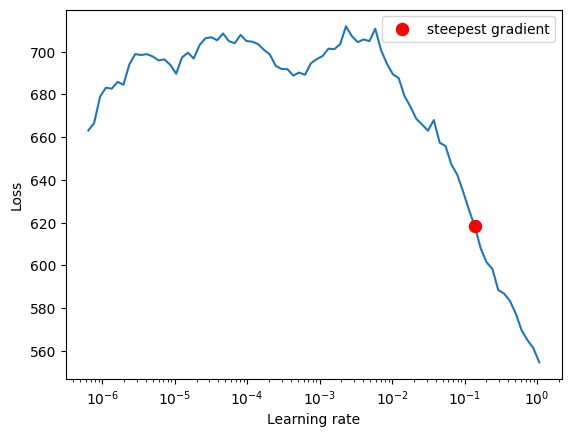

In [46]:
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers = NUM_WORKERS, pin_memory=True, collate_fn=pad_collate)
lr_finder.range_test(train_loader, start_lr=1e-7, end_lr=10, num_iter=100)
lr_finder.plot()  
plt.show()

## Train model

In [8]:
seq_model = Seq1Model(in_ch = in_channels, out_ch = N_CLASSES, lr = 2e-2, weight_decay = 5e-4)

trainer = L.Trainer(
    accelerator="gpu",
    devices=[0],
    max_epochs=5,
    gradient_clip_val=1,
    enable_progress_bar = True,
    num_sanity_val_steps=0
)


trainer.fit(seq_model)
trainer.test(seq_model)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
2025-03-24 17:55:16.606468: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-24 17:55:16.622333: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742

Training: |                                                                                       | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| Current_epoch: 0.00000 | Val_loss: 540.19293 | Train_loss: 490.24277 |
| Val_pearson_r_K562: 0.31592 | Val_pearson_r_HepG2: 0.19335 | Mean_val_pearson_r: 0.25463 |
----------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| Current_epoch: 1.00000 | Val_loss: 527.87921 | Train_loss: 417.34525 |
| Val_pearson_r_K562: 0.38951 | Val_pearson_r_HepG2: 0.23782 | Mean_val_pearson_r: 0.31367 |
----------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| Current_epoch: 2.00000 | Val_loss: 537.45618 | Train_loss: 403.69153 |
| Val_pearson_r_K562: 0.41786 | Val_pearson_r_HepG2: 0.26595 | Mean_val_pearson_r: 0.34191 |
----------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| Current_epoch: 3.00000 | Val_loss: 518.38470 | Train_loss: 397.89410 |
| Val_pearson_r_K562: 0.42518 | Val_pearson_r_HepG2: 0.27730 | Mean_val_pearson_r: 0.35124 |
----------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…

`Trainer.fit` stopped: `max_epochs=5` reached.



----------------------------------------------------------------------------------------------------
| Current_epoch: 4.00000 | Val_loss: 502.80157 | Train_loss: 393.30511 |
| Val_pearson_r_K562: 0.44099 | Val_pearson_r_HepG2: 0.29041 | Mean_val_pearson_r: 0.36570 |
----------------------------------------------------------------------------------------------------



LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing: |                                                                                        | 0/? [00:00…

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │     487.7866516113281     │
│     test_pears_HepG2      │    0.3168551027774811     │
│      test_pears_K562      │    0.4457147419452667     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 487.7866516113281,
  'test_pears_K562': 0.4457147419452667,
  'test_pears_HepG2': 0.3168551027774811}]